In [2]:
import os
os.chdir("..")
os.getcwd()

'/Users/oscarmauriciomoraarroyo/proyecto_lyapunov_chagas'

Cargar datos reales y simulados

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Serie real del foco (Valledupar)
agg_path = "data/clean/chagas_prepared.csv"
agg = pd.read_csv(agg_path)

DEP = "CESAR"
MPIO = "VALLEDUPAR"

real = (
    agg[
        (agg["Departamento_residencia"] == DEP)
        & (agg["Municipio_residencia"] == MPIO)
    ]
    .copy()
    .sort_values(["ANO", "SEMANA"])
)

real.head()

,ANO,SEMANA,Departamento_residencia,Municipio_residencia,casos
10,2024,1,CESAR,VALLEDUPAR,2
66,2024,4,CESAR,VALLEDUPAR,1
110,2024,7,CESAR,VALLEDUPAR,6
132,2024,9,CESAR,VALLEDUPAR,1
146,2024,10,CESAR,VALLEDUPAR,1


Construir fecha y serie temporal

In [4]:
real["fecha"] = pd.to_datetime(
    real["ANO"].astype(str) + real["SEMANA"].astype(str) + "1",
    format="%G%V%u",
)

real_ts = real[["fecha", "casos"]].sort_values("fecha").reset_index(drop=True)
real_ts.head()

,fecha,casos
0,2024-01-01,2
1,2024-01-22,1
2,2024-02-12,6
3,2024-02-26,1
4,2024-03-04,1


Cargar simulación

In [5]:
sim = pd.read_csv("reports/seir_simulation.csv")
sim.head()

,t,S,E,I,R,V
0,0.0,3499.000000,0.000000,1.000000,0.000000,1.000000
1,1.0,2806.379080,627.953752,6.332221,0.015502,1.137470
2,2.0,2155.509639,1205.482731,21.289228,0.087186,1.785650
3,3.0,1457.541847,1821.538793,45.700801,0.266126,3.414782
4,4.0,792.984884,2395.461387,79.650962,0.602845,6.496732


Ajustar la simulación a la ventana de datos reales: La simulación está en días (t 0–365). Los datos reales son semanales.

Convertir simulación a semanas y recortar

In [6]:
sim_weeks = (
    sim.assign(week=(sim["t"] / 7.0))
    .groupby(sim["t"] // 7)[["I"]]
    .mean()
    .reset_index(drop=True)
)

sim_weeks.head()

,I
0,62.821613
1,323.479150
2,526.984464
3,647.829672
4,709.254939


In [7]:
n_real = len(real_ts)
n_sim = len(sim_weeks)

n = min(n_real, n_sim)

real_trim = real_ts.iloc[:n].copy()
sim_trim = sim_weeks.iloc[:n].copy()

Escalar I(t) a unidades de “casos”: Tomamos un factor simple para que los picos sean comparables.

In [8]:
if sim_trim["I"].max() > 0:
    k = real_trim["casos"].max() / sim_trim["I"].max()
else:
    k = 1.0

sim_trim["casos_modelo"] = sim_trim["I"] * k

Gráfico comparativo

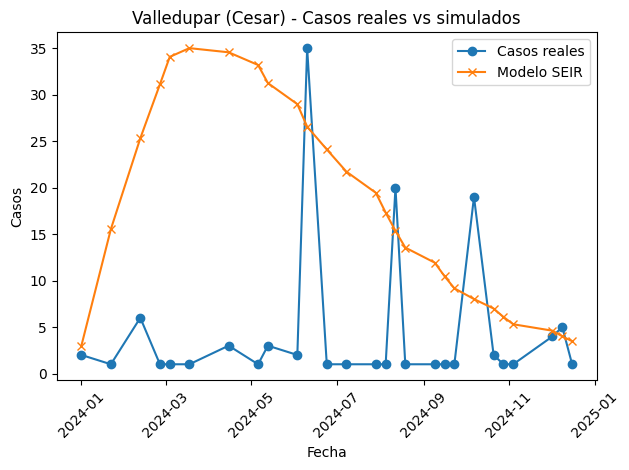

In [9]:
plt.figure()
plt.plot(real_trim["fecha"], real_trim["casos"], marker="o", label="Casos reales")
plt.plot(real_trim["fecha"], sim_trim["casos_modelo"], marker="x", label="Modelo SEIR")
plt.xlabel("Fecha")
plt.ylabel("Casos")
plt.title("Valledupar (Cesar) - Casos reales vs simulados")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Medida simple de error: Este RMSE te sirve luego para justificar ajustes de parámetros.

In [12]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(
    real_trim["casos"],
    sim_trim["casos_modelo"]
)

rmse = mse ** 0.5
rmse

18.847417527126535

imports extra y lectura de parámetros base

In [13]:
from pathlib import Path
import json
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import differential_evolution

PARAMS_PATH = Path("models/seir_params.json")

with PARAMS_PATH.open() as f:
    base_params = json.load(f)

base_params

{'beta': 0.2,
 'alpha': 0.01,
 'sigma': 0.016666666666666666,
 'gamma': 0.005555555555555556,
 'mu': 3.913894324853229e-05,
 'c': 0.05,
 'd': 0.0027397260273972603,
 'N0': 3500.0,
 'm_out': 0.017094017094017096}

sistema SEIR (el mismo de simulate_seir.py)

In [14]:
def seir_system(t, y, p):
    S, E, I, R, V = y
    beta = p["beta"]
    alpha = p["alpha"]
    sigma = p["sigma"]
    gamma = p["gamma"]
    mu = p["mu"]
    c = p["c"]
    d = p["d"]
    m_out = p.get("m_out", 0.0)

    N = S + E + I + R
    if N <= 0:
        return [0.0, 0.0, 0.0, 0.0, 0.0]

    infection = beta * S * V / (1.0 + alpha * I)

    dSdt = p["Lambda"] - infection - (mu + m_out) * S
    dEdt = infection - (sigma + mu + m_out) * E
    dIdt = sigma * E - (gamma + mu + m_out) * I
    dRdt = gamma * I - (mu + m_out) * R
    dVdt = c * I - d * V

    return [dSdt, dEdt, dIdt, dRdt, dVdt]

Función de simulación diaria

In [15]:
def simulate_seir(params, n_days):
    p = params.copy()
    N0 = p["N0"]
    I0 = p.get("I0", 1.0)
    E0 = p.get("E0", 0.0)
    R0 = 0.0
    V0 = 1.0
    S0 = N0 - I0 - E0 - R0

    # nacimiento / entrada
    p.setdefault("Lambda", p["mu"] * N0)

    t_span = (0.0, float(n_days))
    t_eval = np.arange(0, n_days + 1)

    sol = solve_ivp(
        lambda t, y: seir_system(t, y, p),
        t_span=t_span,
        y0=[S0, E0, I0, R0, V0],
        t_eval=t_eval,
        vectorized=False,
    )

    return sol.t, sol.y

In [16]:
t_test, y_test = simulate_seir(base_params, 365)
len(t_test), y_test.shape

(366, (5, 366))

Función objetivo: RMSE entre datos reales y modelo

Función que calcula el RMSE para un conjunto de parámetros

In [17]:
n_weeks = len(real_trim)
n_days = int(n_weeks * 7)


def rmse_for_params(beta, c, N0):
    params = base_params.copy()
    params["beta"] = float(beta)
    params["c"] = float(c)
    params["N0"] = float(N0)

    t, y = simulate_seir(params, n_days)
    I = y[2]  # compartimiento infecciosos

    sim_df = (
        pd.DataFrame({"t": t, "I": I})
        .assign(week=lambda df: (df["t"] // 7).astype(int))
        .groupby("week")["I"]
        .mean()
        .reset_index(drop=True)
    )

    n = min(len(real_trim), len(sim_df))
    real = real_trim["casos"].iloc[:n].to_numpy()
    sim_I = sim_df.iloc[:n].to_numpy()

    if sim_I.max() > 0:
        k = real.max() / sim_I.max()
    else:
        k = 1.0

    sim_cases = sim_I * k
    rmse = np.sqrt(np.mean((real - sim_cases) ** 2))
    return float(rmse)

In [18]:
rmse_for_params(base_params["beta"], base_params["c"], base_params["N0"])

18.847417527126535

Optimización con differential_evolution

Función objetivo para el optimizador

In [19]:
def objective(x):
    beta, c, N0 = x
    return rmse_for_params(beta, c, N0)

Ejecutar la optimización

In [20]:
beta0 = base_params["beta"]
c0 = base_params["c"]
N0_0 = base_params["N0"]

bounds = [
    (beta0 * 0.2, beta0 * 5.0),   # beta
    (max(0.001, c0 * 0.2), c0 * 5.0),  # c
    (N0_0 * 0.3, N0_0 * 3.0),     # N0
]

result = differential_evolution(
    objective,
    bounds=bounds,
    maxiter=20,
    seed=0,
    polish=True,
)

result.x, result.fun

(array([4.00000000e-02, 1.63132771e-02, 6.91606894e+03]), 18.677695579224483)

Comparar curvas con los parámetros óptimos

Simular con parámetros óptimos y graficar

In [21]:
beta_opt, c_opt, N0_opt = result.x
rmse_opt = result.fun

params_opt = base_params.copy()
params_opt["beta"] = float(beta_opt)
params_opt["c"] = float(c_opt)
params_opt["N0"] = float(N0_opt)

t_opt, y_opt = simulate_seir(params_opt, n_days)
I_opt = y_opt[2]

sim_opt = (
    pd.DataFrame({"t": t_opt, "I": I_opt})
    .assign(week=lambda df: (df["t"] // 7).astype(int))
    .groupby("week")["I"]
    .mean()
    .reset_index(drop=True)
)

n = min(len(real_trim), len(sim_opt))
real_plot = real_trim.iloc[:n].copy()
sim_I = sim_opt.iloc[:n].to_numpy()

if sim_I.max() > 0:
    k_opt = real_plot["casos"].max() / sim_I.max()
else:
    k_opt = 1.0

real_plot["modelo_opt"] = sim_I * k_opt

Gráfico comparativo y RMSE

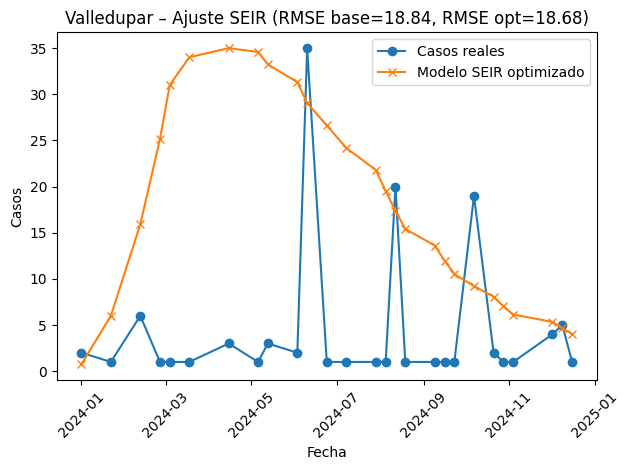

(np.float64(0.04000000000000001),
 np.float64(0.016313277070870564),
 np.float64(6916.06894356012),
 18.677695579224483)

In [22]:
plt.figure()
plt.plot(real_plot["fecha"], real_plot["casos"], marker="o", label="Casos reales")
plt.plot(real_plot["fecha"], real_plot["modelo_opt"], marker="x", label="Modelo SEIR optimizado")
plt.xticks(rotation=45)
plt.xlabel("Fecha")
plt.ylabel("Casos")
plt.title(f"Valledupar – Ajuste SEIR (RMSE base={18.84:.2f}, RMSE opt={rmse_opt:.2f})")
plt.legend()
plt.tight_layout()
plt.show()

beta_opt, c_opt, N0_opt, rmse_opt